In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import LeaveOneOut,StratifiedKFold, cross_val_score
from sklearn.feature_selection import f_classif, SelectKBest, VarianceThreshold, RFECV, SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.learning_curve import learning_curve


In [3]:
def model_generation(file_name_1,file_name_2,output_file_dir):
    x = [] 
    y = []
    with open(file_name_1) as f:
        feature_name = f.readline()
        feature_name = feature_name.rstrip(os.linesep).split(',')
        feature_name = feature_name[1:]
        for line in f:
            x.append([])
            temp = line.rstrip(os.linesep).split(',')
            temp = temp[1:]
            for i in temp:
                if i == '':
                    x[-1].append(np.nan)
                else:
                    x[-1].append(float(i))
        f.close()
    with open(file_name_2) as f:
        for line in f:
            temp = line.rstrip(os.linesep)
            y.append(float(temp))
        f.close()
    x = np.array(x)
    x = x.astype('float32')
    feature_name = np.array(feature_name)
    y2 = []
    for i in y:
        if i >= 0.3:
            y2.append(0)
        elif i>= -1:
            y2.append(1)
        else:
            y2.append(2)
    isnan = ~np.isnan(x).any(axis=0)
    x = x[:,isnan]
#     feature_name = [feature_name[i] for i in range(len(isnan)) if isnan[i] ]
    feature_name = feature_name[isnan]
    isinf = ~np.isinf(x).any(axis=0)
    x = x[:,isinf]
#     feature_name = [feature_name[i] for i in range(len(isinf)) if isinf[i] ]
    feature_name = feature_name[isinf]
    isneginf = ~np.isneginf(x).any(axis=0)
    x = x[:,isneginf]
#     feature_name = [feature_name[i] for i in range(len(isneginf)) if isneginf[i] ]
    feature_name = feature_name[isneginf]
    sel = VarianceThreshold()
    x = sel.fit_transform(x)
#     feature_name = [feature_name[i] for i in range(len(sel.get_support())) if sel.get_support()[i]]
#     print(sel.get_support)
    feature_name = feature_name[sel.get_support()]
    clf = ExtraTreesClassifier(100000)
    clf = clf.fit(x, y2)
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    print("Feature ranking:")
    for feature in range(x.shape[1]):
        print("%d. %s (%f)" % (feature + 1, feature_name[indices[feature]], importances[indices[feature]]))
    plt.figure()
    plt.plot(importances[indices])
    plt.title('Feature Importance in Descending Order')
    plt.xlabel('Ranking')
    plt.ylabel('Importance score')
    plt.savefig(output_file_dir+'feature_importance_des_order.png')
    plt.show()
    plt.figure()
    sns.distplot(importances[indices])
    plt.title('Feature Importance Distribution')
    plt.xlabel('Count')
    plt.ylabel('Importance score')
    plt.savefig(output_file_dir+'feature_importance_distribution.png')
    plt.show()
    threshold = np.mean(importances[indices])+2*np.std(importances[indices])
    for i in range(len(importances)):
        if importances[indices[i]]<threshold:
            cutoff_feature_index = i
            break
    print('Number of features left:'+str(cutoff_feature_index))
    x_selected = x[:,indices[0:cutoff_feature_index]]
    feature_name = feature_name[indices[0:cutoff_feature_index]]

    lda = LinearDiscriminantAnalysis()
    lr = LogisticRegression()
    svc = SVC(kernel="linear")

    print('LDA:')
    lda.fit(x_selected,y2)
    y_pred = lda.predict(x_selected)
    print(classification_report(y2, y_pred))

    print('Logistic regression:')
    lr.fit(x_selected,y2)
    y_pred = lr.predict(x_selected)
    print(classification_report(y2, y_pred))

    print('Support vector classification with linear kernel:')
    svc.fit(x_selected,y2)
    y_pred = svc.predict(x_selected)
    print(classification_report(y2, y_pred))
    
    df = pd.DataFrame(x_selected,columns=feature_name)
    corr = df.corr()
    microarray_cmap = LinearSegmentedColormap('microarray', {
            'red': [(0.0, 1.0, 1.0), (0.5, 0.2, 0.2), (1.0, 0.0, 0.0)],
            'green': [(0.0, 0.0, 0.0), (0.5, 0.2, 0.2), (1.0, 1.0, 1.0)],
            'blue': [(0.0, 0.0, 0.0), (0.5, 0.2, 0.2), (1.0, 0.0, 0.0)],
    })
    microarray_cmap.set_bad('w')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    mask =  np.tri(corr.shape[0],k=-1).T
    cax = ax.matshow(np.ma.array(corr,mask=mask), interpolation='none', cmap=microarray_cmap)
    fig.colorbar(cax)
    ax.set_xticklabels(['']+list(corr.columns),rotation='vertical')
    ax.set_yticklabels(['']+list(corr.columns))
    tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.yaxis.set_label_coords(0, 0)
    ax.grid(False)
    plt.savefig(output_file_dir+'correlation.png')
    plt.show()
    
    print('Recursive feature elimination:')
    
    print('LDA + recall_macro:')
    rfecv = RFECV(estimator=lda, step=1, cv=StratifiedKFold(y2, 20), scoring='recall_macro')
    rfecv.fit(x_selected, y2)
    model = rfecv.estimator_
    x_selected_selected = x_selected[:,rfecv.support_]
    feature_name_selected = feature_name[rfecv.support_]
    y_pred = model.predict(x_selected_selected)
    print("Optimal number of features : %d" % rfecv.n_features_)
    print(feature_name_selected)
    print(model.coef_)
    print(classification_report(y2, y_pred))
    print('Leave-one-out cross validation accuracy:')
    print(str(np.mean(cross_val_score(lda,x_selected_selected,y2,cv=LeaveOneOut(len(y2)),scoring='accuracy'))))


    print('LDA + recall_weighted:')
    rfecv = RFECV(estimator=lda, step=1, cv=StratifiedKFold(y2, 20), scoring='recall_weighted')
    rfecv.fit(x_selected, y2)
    model = rfecv.estimator_
    x_selected_selected = x_selected[:,rfecv.support_]
    feature_name_selected = feature_name[rfecv.support_]
    y_pred = model.predict(x_selected_selected)
    print("Optimal number of features : %d" % rfecv.n_features_)
    print(feature_name_selected)
    print(model.coef_)
    print(classification_report(y2, y_pred))
    print('Leave-one-out cross validation accuracy:')
    print(str(np.mean(cross_val_score(lda,x_selected_selected,y2,cv=LeaveOneOut(len(y2)),scoring='accuracy'))))

    print('Logistic regression + recall_macro:')
    rfecv = RFECV(estimator=lr, step=1, cv=StratifiedKFold(y2, 20), scoring='recall_macro')
    rfecv.fit(x_selected, y2)
    model = rfecv.estimator_
    x_selected_selected = x_selected[:,rfecv.support_]
    feature_name_selected = feature_name[rfecv.support_]
    y_pred = model.predict(x_selected_selected)
    print("Optimal number of features : %d" % rfecv.n_features_)
    print(feature_name_selected)
    print(model.coef_)
    print(classification_report(y2, y_pred))
    lr.fit(x_selected_selected,y2)
    y_pred = lr.predict(x_selected_selected)
    train_sizes, train_scores, test_scores = learning_curve(lr,x_selected_selected,y2,scoring='accuracy', cv=LeaveOneOut(len(x_selected_selected)))
    print('Leave-one-out cross validation accuracy:')
    print(str(np.mean(cross_val_score(lr,x_selected_selected,y2,cv=LeaveOneOut(len(y2)),scoring='accuracy'))))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.title('Learning Curve')
    plt.xlabel('Training Sample Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(output_file_dir+'learning_curve_logistic_recall_macro.png')
    plt.show()

    print('Logistic regression + recall_weighted:')
    rfecv = RFECV(estimator=lr, step=1, cv=StratifiedKFold(y2, 20), scoring='recall_weighted')
    rfecv.fit(x_selected, y2)
    model = rfecv.estimator_
    x_selected_selected = x_selected[:,rfecv.support_]
    feature_name_selected = feature_name[rfecv.support_]
    y_pred = model.predict(x_selected_selected)
    print("Optimal number of features : %d" % rfecv.n_features_)
    print(feature_name_selected)
    print(model.coef_)
    print(classification_report(y2, y_pred))
    lr.fit(x_selected_selected,y2)
    y_pred = lr.predict(x_selected_selected)
    train_sizes, train_scores, test_scores = learning_curve(lr,x_selected_selected,y2,scoring='accuracy', cv=LeaveOneOut(len(x_selected_selected)))
    print('Leave-one-out cross validation accuracy:')
    print(str(np.mean(cross_val_score(lr,x_selected_selected,y2,cv=LeaveOneOut(len(y2)),scoring='accuracy'))))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.title('Learning Curve')
    plt.xlabel('Training Sample Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(output_file_dir+'learning_curve_logistic_recall_weighted.png')
    plt.show()

    print('SVC(linear) + recall_macro:')
    rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y2, 20), scoring='recall_macro')
    rfecv.fit(x_selected, y2)
    model = rfecv.estimator_
    x_selected_selected = x_selected[:,rfecv.support_]
    feature_name_selected = feature_name[rfecv.support_]
    y_pred = model.predict(x_selected_selected)
    print("Optimal number of features : %d" % rfecv.n_features_)
    print(feature_name_selected)
    print(model.coef_)
    print(classification_report(y2, y_pred))
    svc.fit(x_selected_selected,y2)
    y_pred = svc.predict(x_selected_selected)
    train_sizes, train_scores, test_scores = learning_curve(svc,x_selected_selected,y2,scoring='accuracy', cv=LeaveOneOut(len(x_selected_selected)))
    print('Leave-one-out cross validation accuracy:')
    print(str(np.mean(cross_val_score(svc,x_selected_selected,y2,cv=LeaveOneOut(len(y2)),scoring='accuracy'))))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.title('Learning Curve')
    plt.xlabel('Training Sample Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(output_file_dir+'learning_curve_svc_recall_macro.png')
    plt.show()
    
    print('SVC(linear) + recall_weighted:')
    rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y2, 20), scoring='recall_weighted')
    rfecv.fit(x_selected, y2)
    model = rfecv.estimator_
    x_selected_selected = x_selected[:,rfecv.support_]
    feature_name_selected = feature_name[rfecv.support_]
    y_pred = model.predict(x_selected_selected)
    print("Optimal number of features : %d" % rfecv.n_features_)
    print(feature_name_selected)
    print(model.coef_)
    print(classification_report(y2, y_pred))
    svc.fit(x_selected_selected,y2)
    y_pred = svc.predict(x_selected_selected)
    train_sizes, train_scores, test_scores = learning_curve(svc,x_selected_selected,y2,scoring='accuracy', cv=LeaveOneOut(len(x_selected_selected)))
    print('Leave-one-out cross validation accuracy:')
    print(str(np.mean(cross_val_score(svc,x_selected_selected,y2,cv=LeaveOneOut(len(y2)),scoring='accuracy'))))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.title('Learning Curve')
    plt.xlabel('Training Sample Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(output_file_dir+'learning_curve_svc_recall_weighted.png')
    plt.show()


Use PaDEL 1D+2D descriptors

Feature ranking:
1. mindO (0.009649)
2. maxdO (0.009352)
3. maxHBint2 (0.005909)
4. maxHBd (0.004546)
5. nBondsD2 (0.004496)
6. nBondsD (0.004452)
7. ndO (0.004272)
8. TopoPSA (0.003914)
9. SdO (0.003765)
10. XLogP (0.003740)
11. ETA_dPsi_A (0.003474)
12. SHBint2 (0.003354)
13. nHBAcc_Lipinski (0.003254)
14. nHBint2 (0.003235)
15. minHBint2 (0.003039)
16. CrippenLogP (0.003017)
17. nO (0.002874)
18. maxHBa (0.002873)
19. SHBd (0.002857)
20. minHBd (0.002838)
21. MDEO-11 (0.002769)
22. GATS2e (0.002755)
23. LipoaffinityIndex (0.002738)
24. maxssCH2 (0.002728)
25. maxHBint4 (0.002702)
26. nHBAcc (0.002686)
27. MDEN-22 (0.002616)
28. ETA_Psi_1 (0.002615)
29. WTPT-4 (0.002443)
30. ETA_dAlpha_B (0.002435)
31. C1SP2 (0.002393)
32. MLFER_A (0.002342)
33. CIC1 (0.002285)
34. CIC2 (0.002280)
35. MLFER_S (0.002269)
36. nBase (0.002262)
37. maxHsOH (0.002261)
38. AATSC0c (0.002241)
39. GATS2s (0.002232)
40. maxaasC (0.002220)
41. ETA_Epsilon_2 (0.002216)
42. AATSC1c (0.002212)
43. MAXDP2 (0.00219

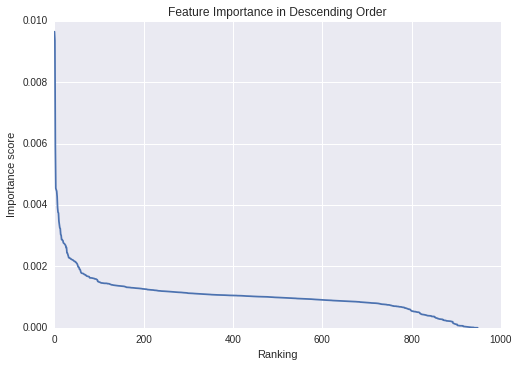

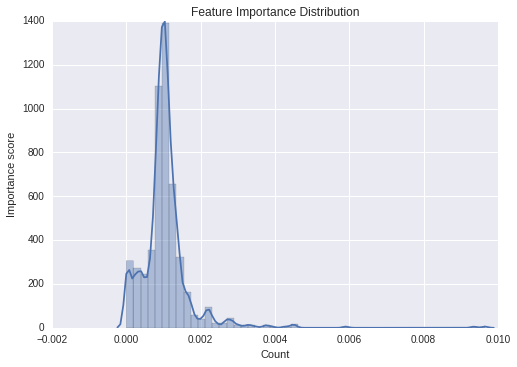

Number of features left:28
LDA:
             precision    recall  f1-score   support

          0       0.71      0.70      0.71       206
          1       0.73      0.77      0.75       300
          2       0.63      0.52      0.57        75

avg / total       0.71      0.71      0.71       581

Logistic regression:
             precision    recall  f1-score   support

          0       0.71      0.69      0.70       206
          1       0.71      0.80      0.75       300
          2       0.64      0.39      0.48        75

avg / total       0.70      0.71      0.70       581

Support vector classification with linear kernel:
             precision    recall  f1-score   support

          0       0.70      0.69      0.69       206
          1       0.71      0.80      0.75       300
          2       0.72      0.37      0.49        75

avg / total       0.70      0.70      0.70       581



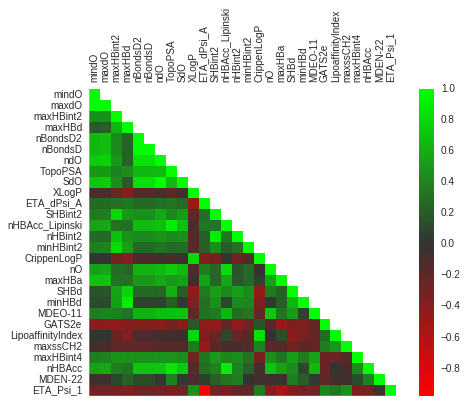

Recursive feature elimination:
LDA + recall_macro:
Optimal number of features : 28
['mindO' 'maxdO' 'maxHBint2' 'maxHBd' 'nBondsD2' 'nBondsD' 'ndO' 'TopoPSA'
 'SdO' 'XLogP' 'ETA_dPsi_A' 'SHBint2' 'nHBAcc_Lipinski' 'nHBint2'
 'minHBint2' 'CrippenLogP' 'nO' 'maxHBa' 'SHBd' 'minHBd' 'MDEO-11' 'GATS2e'
 'LipoaffinityIndex' 'maxssCH2' 'maxHBint4' 'nHBAcc' 'MDEN-22' 'ETA_Psi_1']
[[ -4.10174258e-03  -1.17035333e-01   7.49840628e-02  -1.31005770e+00
   -9.32652697e-02  -9.32662779e-02   4.78912618e-01  -4.98601337e-03
   -3.72550364e-02   1.14018181e-01  -1.54959724e+00   9.24500692e-02
   -7.83908769e-02  -4.39105891e-01  -1.25508204e-01   1.36903187e-01
   -3.39852738e-02   7.84190697e-02   6.14959612e-02  -3.80688929e-02
    1.64458561e-01   2.95692366e-01  -7.98037436e-02   4.26526298e-01
    2.56132488e-02   1.82896219e-01  -3.67813050e-01   2.52112835e+00]
 [  3.08032982e-01  -2.91204907e-01  -9.63897037e-02   1.38932121e+00
    4.54577578e-02   4.54573719e-02   1.82738241e-01  -1.664557

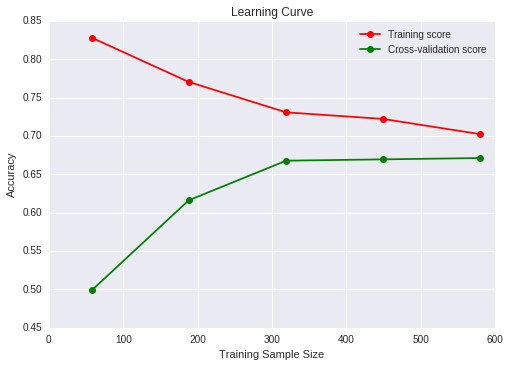

Logistic regression + recall_weighted:
Optimal number of features : 20
['mindO' 'maxdO' 'maxHBd' 'nBondsD2' 'nBondsD' 'ETA_dPsi_A'
 'nHBAcc_Lipinski' 'nHBint2' 'CrippenLogP' 'nO' 'maxHBa' 'SHBd' 'minHBd'
 'MDEO-11' 'GATS2e' 'LipoaffinityIndex' 'maxssCH2' 'nHBAcc' 'MDEN-22'
 'ETA_Psi_1']
[[-0.03814977 -0.06055482 -0.54773703 -0.20829604 -0.20829604 -1.00773654
  -0.50973045 -0.24965205  0.28830262  0.13221106  0.02354942 -0.22998035
  -0.49150463 -0.19524634  0.02268375  0.01483964  0.53014812  0.42948093
  -0.23628238  0.60258352]
 [ 0.3272194  -0.29784235  0.73306604  0.12288858  0.12288858  0.80583438
   0.26454373  0.26079319  0.03446145 -0.22013877  0.05496527 -0.4284324
   0.04018046 -0.19417602  0.0418011  -0.17019557 -0.26757207 -0.1718776
  -0.79400935 -0.50508421]
 [-0.2419369   0.47856566  0.98265866 -0.0646811  -0.0646811  -0.48097603
   0.04012673 -0.42338947 -0.33371974  0.27973292 -0.31553288  0.85290646
   0.79067928 -0.14930734 -1.65374659  0.30607362 -0.24333404 -0.016

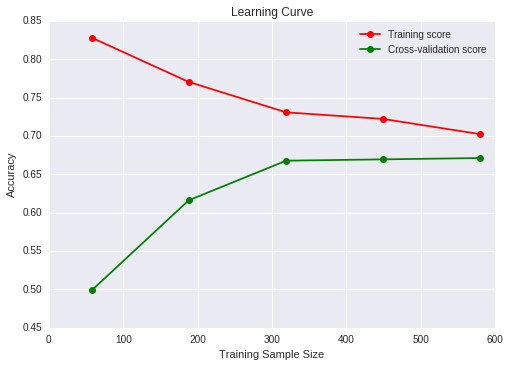

SVC(linear) + recall_macro:
Optimal number of features : 23
['mindO' 'maxdO' 'maxHBint2' 'maxHBd' 'nBondsD' 'ndO' 'XLogP' 'ETA_dPsi_A'
 'nHBAcc_Lipinski' 'nHBint2' 'minHBint2' 'CrippenLogP' 'nO' 'maxHBa' 'SHBd'
 'minHBd' 'MDEO-11' 'GATS2e' 'LipoaffinityIndex' 'maxssCH2' 'nHBAcc'
 'MDEN-22' 'ETA_Psi_1']
[[-0.36747863  0.33390088  0.11182679 -0.41920429 -0.34990904 -0.50965063
   0.17755605 -0.93912781 -0.40734035 -0.24241372 -0.19310597  0.06443688
   0.17747616  0.02902202  0.14936437 -0.2454165   0.12132407 -0.09367797
   0.04506876  0.39177018  0.30998865 -0.08878766  1.18565789]
 [ 0.22560248 -0.40117091  0.17184531 -0.47122903 -0.00771993 -0.14460431
  -0.11487897 -0.03926889 -0.06575407 -0.12499711 -0.29115453  0.76291119
  -0.21480489  0.25694445 -1.33169803 -0.54113329  0.13557018  0.72214301
  -0.40169344  0.5052139   0.01495963 -0.81137146  0.18496885]
 [ 0.39135972 -0.52020487  0.01804022 -0.2560329  -0.01791591  0.60686523
   0.07750337  0.45190352  0.08070945  0.05781946  0

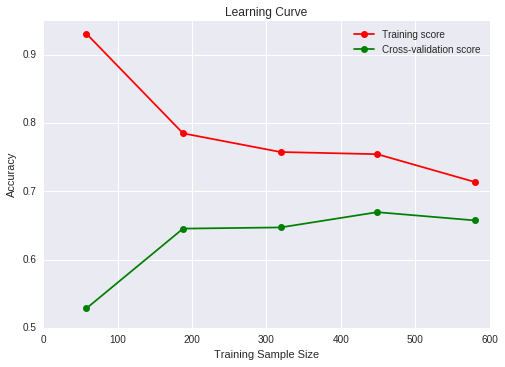

SVC(linear) + recall_weighted:

Optimal number of features : 23
['mindO' 'maxdO' 'maxHBint2' 'maxHBd' 'nBondsD' 'ndO' 'XLogP' 'ETA_dPsi_A'
 'nHBAcc_Lipinski' 'nHBint2' 'minHBint2' 'CrippenLogP' 'nO' 'maxHBa' 'SHBd'
 'minHBd' 'MDEO-11' 'GATS2e' 'LipoaffinityIndex' 'maxssCH2' 'nHBAcc'
 'MDEN-22' 'ETA_Psi_1']
[[-0.36747863  0.33390088  0.11182679 -0.41920429 -0.34990904 -0.50965063
   0.17755605 -0.93912781 -0.40734035 -0.24241372 -0.19310597  0.06443688
   0.17747616  0.02902202  0.14936437 -0.2454165   0.12132407 -0.09367797
   0.04506876  0.39177018  0.30998865 -0.08878766  1.18565789]
 [ 0.22560248 -0.40117091  0.17184531 -0.47122903 -0.00771993 -0.14460431
  -0.11487897 -0.03926889 -0.06575407 -0.12499711 -0.29115453  0.76291119
  -0.21480489  0.25694445 -1.33169803 -0.54113329  0.13557018  0.72214301
  -0.40169344  0.5052139   0.01495963 -0.81137146  0.18496885]
 [ 0.39135972 -0.52020487  0.01804022 -0.2560329  -0.01791591  0.60686523
   0.07750337  0.45190352  0.08070945  0.0578194

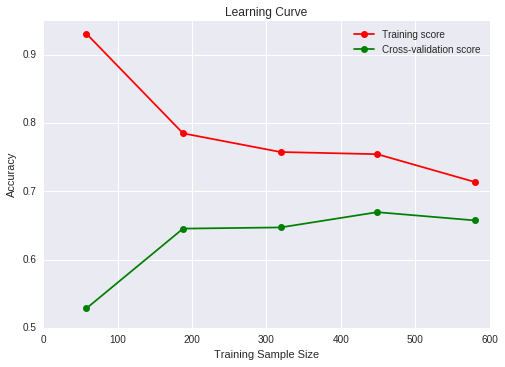

In [4]:
model_generation('../data/features.csv','../data/logBB.txt','../data/features/')

Use PubChem fingerprint

Feature ranking:
1. PubchemFP19 (0.013100)
2. PubchemFP420 (0.010045)
3. PubchemFP18 (0.009992)
4. PubchemFP20 (0.009537)
5. PubchemFP443 (0.008655)
6. PubchemFP335 (0.007733)
7. PubchemFP582 (0.007223)
8. PubchemFP308 (0.007088)
9. PubchemFP16 (0.007023)
10. PubchemFP451 (0.006867)
11. PubchemFP12 (0.006743)
12. PubchemFP2 (0.006680)
13. PubchemFP406 (0.006411)
14. PubchemFP643 (0.006330)
15. PubchemFP535 (0.006264)
16. PubchemFP286 (0.006008)
17. PubchemFP185 (0.005952)
18. PubchemFP679 (0.005921)
19. PubchemFP299 (0.005921)
20. PubchemFP374 (0.005886)
21. PubchemFP393 (0.005837)
22. PubchemFP346 (0.005827)
23. PubchemFP696 (0.005771)
24. PubchemFP440 (0.005664)
25. PubchemFP708 (0.005586)
26. PubchemFP579 (0.005439)
27. PubchemFP617 (0.005182)
28. PubchemFP560 (0.005160)
29. PubchemFP528 (0.005043)
30. PubchemFP452 (0.004965)
31. PubchemFP186 (0.004965)
32. PubchemFP392 (0.004958)
33. PubchemFP333 (0.004834)
34. PubchemFP352 (0.004821)
35. PubchemFP439 (0.004820)
36. PubchemFP697 (0

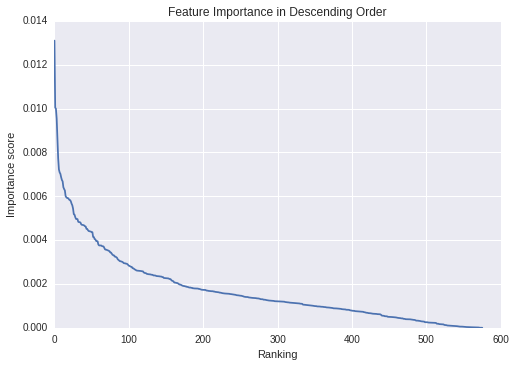

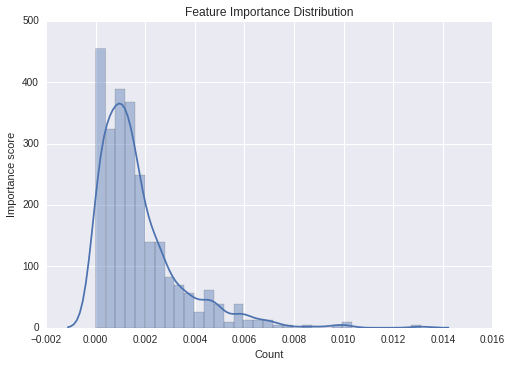

Number of features left:28
LDA:
             precision    recall  f1-score   support

          0       0.71      0.69      0.70       206
          1       0.70      0.73      0.71       300
          2       0.54      0.51      0.52        75

avg / total       0.68      0.69      0.68       581

Logistic regression:
             precision    recall  f1-score   support

          0       0.70      0.67      0.69       206
          1       0.67      0.81      0.73       300
          2       0.64      0.19      0.29        75

avg / total       0.68      0.68      0.66       581

Support vector classification with linear kernel:
             precision    recall  f1-score   support

          0       0.72      0.67      0.70       206
          1       0.65      0.84      0.74       300
          2       0.00      0.00      0.00        75

avg / total       0.59      0.67      0.63       581



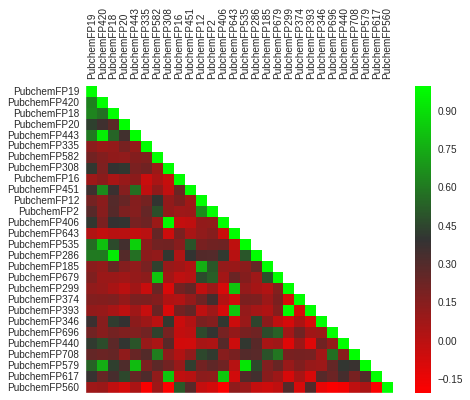

Recursive feature elimination:
LDA + recall_macro:
Optimal number of features : 28
['PubchemFP19' 'PubchemFP420' 'PubchemFP18' 'PubchemFP20' 'PubchemFP443'
 'PubchemFP335' 'PubchemFP582' 'PubchemFP308' 'PubchemFP16' 'PubchemFP451'
 'PubchemFP12' 'PubchemFP2' 'PubchemFP406' 'PubchemFP643' 'PubchemFP535'
 'PubchemFP286' 'PubchemFP185' 'PubchemFP679' 'PubchemFP299' 'PubchemFP374'
 'PubchemFP393' 'PubchemFP346' 'PubchemFP696' 'PubchemFP440' 'PubchemFP708'
 'PubchemFP579' 'PubchemFP617' 'PubchemFP560']
[[ -3.33595296e-01  -4.11311447e-01  -2.10082891e+00  -8.07669646e-01
   -2.98151558e-01   1.05689285e-01   9.43050533e-01  -1.58932770e+00
   -7.01344902e-01   1.93844427e-02   3.06623387e-01   6.04275406e-01
    1.30468520e+00   2.61915521e-01   9.46820697e-01   1.66663279e+00
    1.99616721e-01  -7.61992356e-02  -1.58868895e+00  -1.79341126e-01
    1.13324372e+00  -8.51952790e-03  -1.35347027e-03  -1.01907650e-01
   -1.74580310e-02  -1.17810461e+00  -4.15277001e-01  -7.48077826e-01]
 [  2.

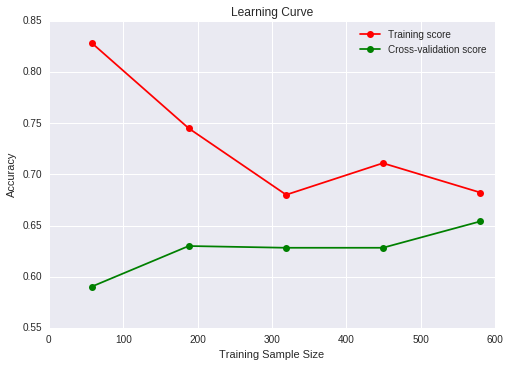

Logistic regression + recall_weighted:
Optimal number of features : 18
['PubchemFP19' 'PubchemFP18' 'PubchemFP20' 'PubchemFP443' 'PubchemFP582'
 'PubchemFP308' 'PubchemFP16' 'PubchemFP451' 'PubchemFP2' 'PubchemFP643'
 'PubchemFP286' 'PubchemFP185' 'PubchemFP299' 'PubchemFP393' 'PubchemFP440'
 'PubchemFP579' 'PubchemFP617' 'PubchemFP560']
[[-0.55238926 -1.77393801 -1.38311355 -0.48656412  0.93153683 -0.38596918
  -1.06964699 -0.34981442  0.93722225  0.72903065  1.17506954  0.7508067
  -0.60715352 -0.44171234 -0.13084014 -0.37381825 -0.67189733 -0.95676596]
 [ 0.47735677  1.95248061  0.24650091 -0.29312242 -0.99478516 -0.07984476
  -0.46674713  0.46674412 -0.59361567 -1.0061007  -1.20749712 -0.3762541
   0.69240702  0.39544376 -0.49989029  0.69331199  0.30703241  0.4204646 ]
 [ 0.32338181 -0.94364066  0.73014094  1.14957493  0.17938557  0.72555316
   1.60709925 -0.74874881 -0.36110758  0.9949763   0.17807505 -0.18762062
  -0.47687959 -0.44422243  0.88659147 -0.24210749  0.0212156   0.728

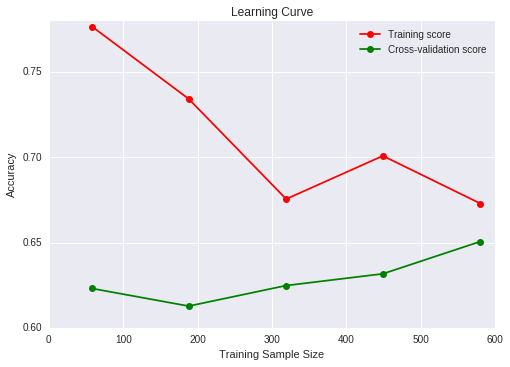

SVC(linear) + recall_macro:
Optimal number of features : 27
['PubchemFP19' 'PubchemFP420' 'PubchemFP18' 'PubchemFP20' 'PubchemFP443'
 'PubchemFP582' 'PubchemFP308' 'PubchemFP16' 'PubchemFP451' 'PubchemFP12'
 'PubchemFP2' 'PubchemFP406' 'PubchemFP643' 'PubchemFP535' 'PubchemFP286'
 'PubchemFP185' 'PubchemFP679' 'PubchemFP299' 'PubchemFP374' 'PubchemFP393'
 'PubchemFP346' 'PubchemFP696' 'PubchemFP440' 'PubchemFP708' 'PubchemFP579'
 'PubchemFP617' 'PubchemFP560']
[[ -4.21789966e-01   4.28455849e-01  -1.87434251e+00  -8.52367753e-01
   -3.20749900e-01   1.14539440e+00  -5.71593294e-01  -9.62610023e-01
   -9.61476238e-01   2.19419099e-01   5.72141333e-01   4.28406706e-01
    1.53860405e-01   3.12249756e-01   1.30144881e+00   7.72670711e-02
    1.28734268e-01  -3.52729603e-01  -2.19156462e-01  -9.69338453e-02
    2.00985530e-01   1.25007273e-01  -3.54125849e-01   4.47670169e-01
   -7.16217643e-01  -7.83281766e-01  -6.15701942e-01]
 [ -2.46430995e-01  -3.93699333e-01   6.25604360e-02  -1.7627

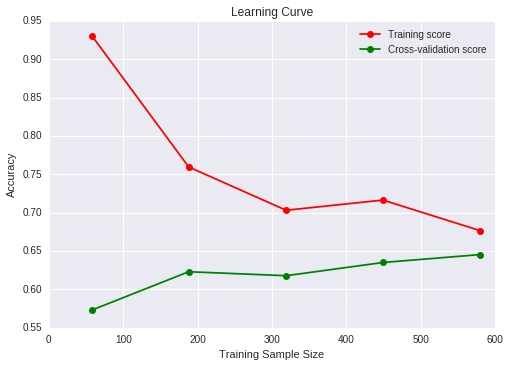

SVC(linear) + recall_weighted:

Optimal number of features : 25
['PubchemFP19' 'PubchemFP420' 'PubchemFP18' 'PubchemFP20' 'PubchemFP443'
 'PubchemFP582' 'PubchemFP308' 'PubchemFP16' 'PubchemFP451' 'PubchemFP12'
 'PubchemFP2' 'PubchemFP406' 'PubchemFP643' 'PubchemFP535' 'PubchemFP286'
 'PubchemFP185' 'PubchemFP679' 'PubchemFP299' 'PubchemFP374' 'PubchemFP696'
 'PubchemFP440' 'PubchemFP708' 'PubchemFP579' 'PubchemFP617' 'PubchemFP560']
[[ -3.38256547e-01   3.59612609e-01  -1.93692282e+00  -7.98924139e-01
   -3.99437413e-01   1.15054509e+00  -5.30228280e-01  -9.46728161e-01
   -1.01114759e+00   2.49703094e-01   4.64612271e-01   4.69771720e-01
    1.68900423e-01   3.72344475e-01   1.47223348e+00   4.52372665e-02
    1.50545094e-01  -4.64356781e-01  -2.50066260e-01   6.34996220e-02
   -5.04373646e-01   4.21149089e-01  -6.27655525e-01  -8.02452171e-01
   -6.51225703e-01]
 [ -2.07237896e-01  -3.98774999e-01   1.04971709e-01  -1.64167264e+00
   -2.23797222e-02  -5.48353365e-01  -1.07575616e+00

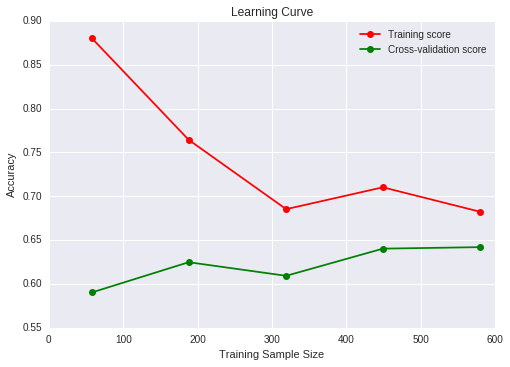

In [5]:
model_generation('../data/features2.csv','../data/logBB.txt','../data/features2/')

Use PaDEL 1D+2D descriptors + PubChem fingerprint

Feature ranking:
1. mindO (0.006781)
2. maxdO (0.006748)
3. PubchemFP19 (0.004808)
4. maxHBint2 (0.004320)
5. PubchemFP420 (0.004258)
6. PubchemFP443 (0.003645)
7. maxHBd (0.003531)
8. nBondsD2 (0.003359)
9. nBondsD (0.003260)
10. PubchemFP18 (0.003139)
11. ndO (0.003056)
12. XLogP (0.002985)
13. TopoPSA (0.002959)
14. SdO (0.002761)
15. PubchemFP535 (0.002701)
16. ETA_dPsi_A (0.002693)
17. PubchemFP16 (0.002610)
18. CrippenLogP (0.002552)
19. SHBint2 (0.002481)
20. nHBint2 (0.002379)
21. PubchemFP20 (0.002374)
22. PubchemFP451 (0.002362)
23. nHBAcc_Lipinski (0.002342)
24. minHBint2 (0.002308)
25. PubchemFP579 (0.002277)
26. SHBd (0.002259)
27. LipoaffinityIndex (0.002212)
28. minHBd (0.002197)
29. maxssCH2 (0.002152)
30. nO (0.002149)
31. MDEO-11 (0.002141)
32. GATS2e (0.002052)
33. ETA_Psi_1 (0.002021)
34. maxHBa (0.002005)
35. maxHBint4 (0.001920)
36. MDEN-22 (0.001908)
37. CIC1 (0.001887)
38. MLFER_A (0.001864)
39. CIC2 (0.001852)
40. nHBAcc (0.001844)
41. WTPT-4 (0.001828)
42. ETA

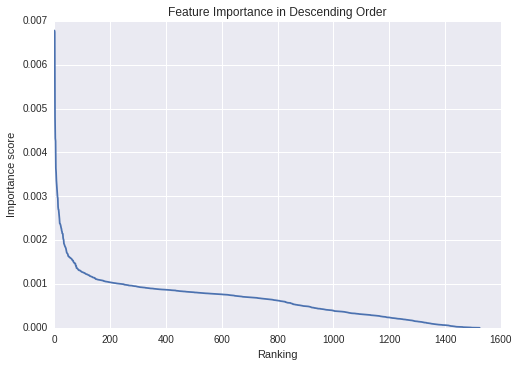

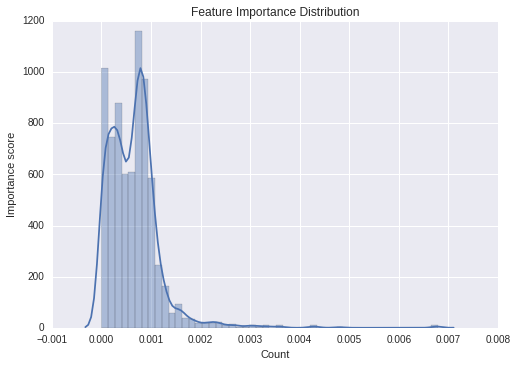

Number of features left:44
LDA:
             precision    recall  f1-score   support

          0       0.72      0.70      0.71       206
          1       0.72      0.77      0.74       300
          2       0.64      0.52      0.57        75

avg / total       0.71      0.71      0.71       581

Logistic regression:
             precision    recall  f1-score   support

          0       0.73      0.72      0.73       206
          1       0.72      0.80      0.76       300
          2       0.69      0.39      0.50        75

avg / total       0.72      0.72      0.71       581

Support vector classification with linear kernel:
             precision    recall  f1-score   support

          0       0.77      0.71      0.74       206
          1       0.72      0.83      0.77       300
          2       0.80      0.44      0.57        75

avg / total       0.75      0.74      0.73       581



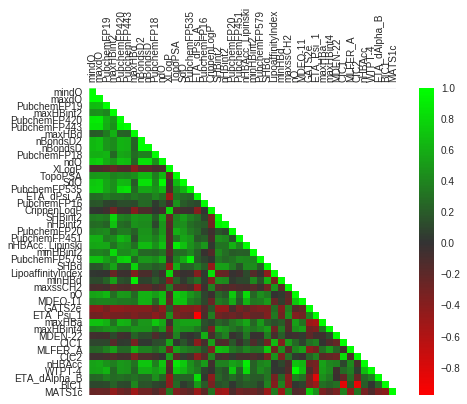

Recursive feature elimination:
LDA + recall_macro:
Optimal number of features : 31
['mindO' 'maxdO' 'PubchemFP19' 'PubchemFP420' 'PubchemFP443' 'maxHBd'
 'PubchemFP18' 'ndO' 'PubchemFP535' 'ETA_dPsi_A' 'PubchemFP16'
 'CrippenLogP' 'nHBint2' 'PubchemFP20' 'PubchemFP451' 'PubchemFP579' 'SHBd'
 'LipoaffinityIndex' 'minHBd' 'maxssCH2' 'nO' 'MDEO-11' 'GATS2e'
 'ETA_Psi_1' 'MDEN-22' 'CIC1' 'CIC2' 'WTPT-4' 'ETA_dAlpha_B' 'BIC1'
 'MATS1c']
[[ -4.98497427e-01   3.92432978e-01   1.15230393e-01   6.83931086e-01
   -2.49179050e-01  -8.30869584e-01   1.34861267e-01   2.70784215e-01
    7.94946880e-01   1.85168738e+00  -7.02311185e-01   1.09514080e-01
   -2.28480774e-01  -3.32595249e-01  -2.80460653e-02  -7.62425177e-01
    5.21446430e-01  -1.40566752e-02  -2.11247726e-01   3.16961105e-01
   -5.04857475e+00   8.18692244e-01   1.02810841e-01   3.03706387e+00
   -2.64302697e-01   4.03749109e-01   4.87721356e-01   1.68414353e+00
    3.41331058e+00   1.91812813e+00  -1.25941888e-02]
 [  5.80133012e-01  

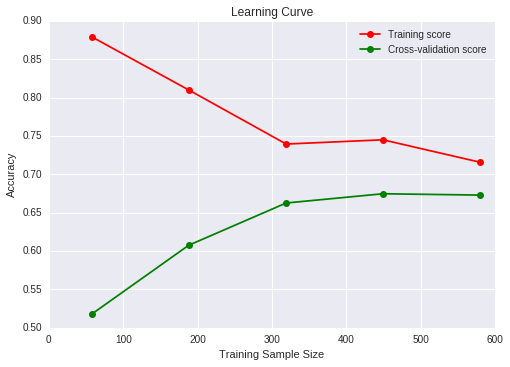

Logistic regression + recall_weighted:
Optimal number of features : 40
['mindO' 'maxdO' 'PubchemFP19' 'maxHBint2' 'PubchemFP420' 'PubchemFP443'
 'maxHBd' 'nBondsD2' 'nBondsD' 'PubchemFP18' 'ndO' 'PubchemFP535'
 'ETA_dPsi_A' 'PubchemFP16' 'CrippenLogP' 'SHBint2' 'nHBint2' 'PubchemFP20'
 'PubchemFP451' 'nHBAcc_Lipinski' 'minHBint2' 'PubchemFP579' 'SHBd'
 'LipoaffinityIndex' 'minHBd' 'maxssCH2' 'nO' 'MDEO-11' 'GATS2e'
 'ETA_Psi_1' 'maxHBa' 'MDEN-22' 'CIC1' 'MLFER_A' 'CIC2' 'nHBAcc' 'WTPT-4'
 'ETA_dAlpha_B' 'BIC1' 'MATS1c']
[[ -2.98536797e-01   1.60032831e-01   8.18578529e-02  -5.24183312e-02
    1.00434318e+00   1.64923974e-01  -1.84559617e-01  -1.77387187e-01
   -1.77387187e-01  -4.48233502e-01  -4.95885373e-01   1.75296618e-01
   -7.99117882e-01  -1.21838425e+00   3.13922040e-01   1.38037266e-01
   -5.04634774e-01  -1.21044254e+00   1.05627756e-01  -2.94871414e-01
   -1.73803605e-01  -1.50867264e-01   1.65963849e-01  -2.30171578e-02
   -4.89598011e-01   4.14165571e-01  -1.67576497e+00  

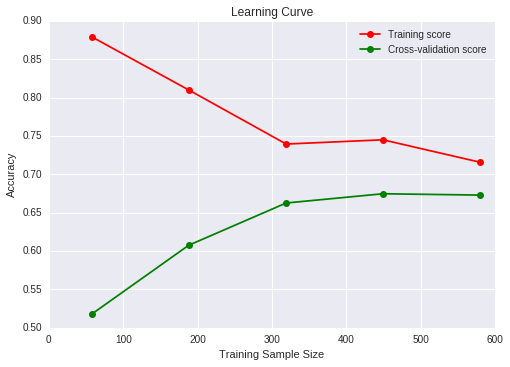

SVC(linear) + recall_macro:
Optimal number of features : 29
['mindO' 'maxdO' 'PubchemFP19' 'PubchemFP420' 'PubchemFP443' 'nBondsD2'
 'PubchemFP18' 'ndO' 'PubchemFP535' 'ETA_dPsi_A' 'PubchemFP16'
 'CrippenLogP' 'PubchemFP20' 'PubchemFP451' 'PubchemFP579' 'SHBd'
 'LipoaffinityIndex' 'minHBd' 'maxssCH2' 'nO' 'MDEO-11' 'ETA_Psi_1'
 'MDEN-22' 'CIC1' 'MLFER_A' 'CIC2' 'WTPT-4' 'ETA_dAlpha_B' 'MATS1c']
[[-0.26312083  0.13861537 -0.30089138  1.32800806  0.1868379  -0.35596727
  -0.44762787  0.10673419  0.45119287 -0.81669072 -0.76076697  0.06168941
  -1.12652409 -0.74908622 -0.63653743  0.1894921   0.15194802 -0.48788301
   0.00644505 -1.61895504  0.11961674  1.06322063 -0.08102545  0.08933683
  -0.8667533   0.47631714  0.65465721 -0.17368015 -0.63050197]
 [ 0.22332003 -0.49228522  0.02870437  0.77815816  0.38480406 -0.02219549
   0.82968121 -0.29549276  0.09891618  0.29450815 -0.79174194  0.51737027
  -0.48094531  1.29872933  0.67003388 -0.75923888 -0.300384   -1.27047239
   0.51130715 -1.4055

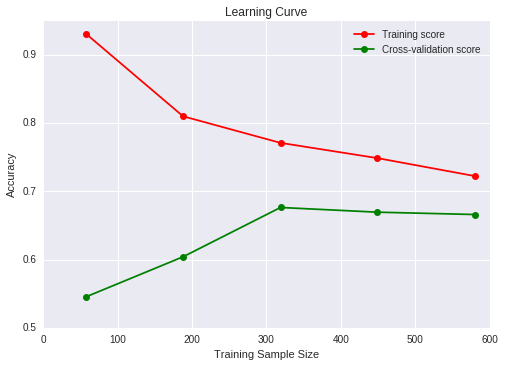

SVC(linear) + recall_weighted:

Optimal number of features : 29
['mindO' 'maxdO' 'PubchemFP19' 'PubchemFP420' 'PubchemFP443' 'nBondsD2'
 'PubchemFP18' 'ndO' 'PubchemFP535' 'ETA_dPsi_A' 'PubchemFP16'
 'CrippenLogP' 'PubchemFP20' 'PubchemFP451' 'PubchemFP579' 'SHBd'
 'LipoaffinityIndex' 'minHBd' 'maxssCH2' 'nO' 'MDEO-11' 'ETA_Psi_1'
 'MDEN-22' 'CIC1' 'MLFER_A' 'CIC2' 'WTPT-4' 'ETA_dAlpha_B' 'MATS1c']
[[-0.26312083  0.13861537 -0.30089138  1.32800806  0.1868379  -0.35596727
  -0.44762787  0.10673419  0.45119287 -0.81669072 -0.76076697  0.06168941
  -1.12652409 -0.74908622 -0.63653743  0.1894921   0.15194802 -0.48788301
   0.00644505 -1.61895504  0.11961674  1.06322063 -0.08102545  0.08933683
  -0.8667533   0.47631714  0.65465721 -0.17368015 -0.63050197]
 [ 0.22332003 -0.49228522  0.02870437  0.77815816  0.38480406 -0.02219549
   0.82968121 -0.29549276  0.09891618  0.29450815 -0.79174194  0.51737027
  -0.48094531  1.29872933  0.67003388 -0.75923888 -0.300384   -1.27047239
   0.51130715 -1.

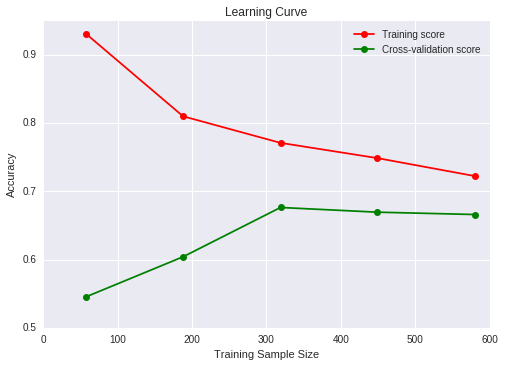

In [6]:
model_generation('../data/features3.csv','../data/logBB.txt','../data/features3/')